# 基于虚假新闻和投资者情绪的机器学习因果推断

我在想一个问题，经过处理的每一个投资者情绪csv，应当转为一个一行的数据。它的文件名就是它的主码（分两种情况，如果只是股票代码组成股票代码就是主码，如果由“股票代码_日期.csv”组成那么“股票代码，日期”）就是主码。

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline

tokenizer = AutoTokenizer.from_pretrained("bardsai/finance-sentiment-zh-fast")
model = AutoModelForSequenceClassification.from_pretrained("bardsai/finance-sentiment-zh-fast")
nlp_bardsai = pipeline("text-classification", model="bardsai/finance-sentiment-zh-fast")

c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import os
import pandas as pd

def analyze_sentiment(text):
    """
    情绪分析的假设函数，返回模拟的情绪分析结果
    """
    return nlp_bardsai(text)

def process_csv(file_path):
    """
    处理单个股票的投资者情绪 CSV 文件
    """
    # 读取文件
    df = pd.read_csv(file_path)
    
    # 删除评论为空的行
    df.dropna(subset=["内容"], inplace=True)
    # 删除评论中的新闻
    df = df[df["内容"].str.len() <= 500]
    
    # 添加情绪分析结果
    df["标题情绪分析"] = df["标题"].apply(lambda x: analyze_sentiment(x) if pd.notna(x) else None)
    df["评论情绪分析"] = df["内容"].apply(lambda x: analyze_sentiment(x) if pd.notna(x) else None)
    
    # 定义函数提取情绪分数
    def calculate_scores(sentiment_results):
        if sentiment_results is None:
            return 0, 0, 0
        neutral = sum(x["score"] for x in sentiment_results if x["label"] == "neutral")
        positive = sum(x["score"] for x in sentiment_results if x["label"] == "positive")
        negative = sum(x["score"] for x in sentiment_results if x["label"] == "negative")
        return neutral, positive, negative

    # 计算标题和评论的情绪分数
    df["标题中性分数"], df["标题积极分数"], df["标题消极分数"] = zip(*df["标题情绪分析"].apply(calculate_scores))
    df["评论中性分数"], df["评论积极分数"], df["评论消极分数"] = zip(*df["评论情绪分析"].apply(calculate_scores))
    
    df["发布时间"] = pd.to_datetime(df["发布时间"])
    # 只保留年月日
    df["发布时间"] = df["发布时间"].dt.date
    
    # 按日期分组
    result = df.groupby("发布时间").agg(
        标题中性分数=("标题中性分数", "mean"),
        标题积极分数=("标题积极分数", "mean"),
        标题消极分数=("标题消极分数", "mean"),
        评论中性分数=("评论中性分数", "mean"),
        评论积极分数=("评论积极分数", "mean"),
        评论消极分数=("评论消极分数", "mean")
    ).reset_index()
    
    # 填充缺失值为 0
    result.fillna(0, inplace=True)
    
    return result

def main(input_folder, output_folder):
    """
    批量处理多个投资者情绪 CSV 文件
    """
    # 确保输出文件夹存在
    os.makedirs(output_folder, exist_ok=True)
    
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            input_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)
            
            print(f"Processing {file_name}...")
            result = process_csv(input_path)
            
            # 保存结果
            result.to_csv(output_path, index=False, encoding="utf-8-sig")
            print(f"Saved to {output_path}")

# 输入和输出文件夹
input_folder = "D:\mycodelife\workshop\\fake_finance\\ready_crawler"
output_folder ="D:\mycodelife\workshop\\fake_finance\\ready_crawler\\result"

# 执行主函数
main(input_folder, output_folder)


Processing 000016_2022-03-01.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000016_2022-03-01.csv
Processing 000018_2016-01-22.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000018_2016-01-22.csv
Processing 000018_2016-07-11.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000018_2016-07-11.csv
Processing 000018_2017-05-23.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000018_2017-05-23.csv
Processing 000038_2016-11-25.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000038_2016-11-25.csv
Processing 000048_2019-10-21.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000048_2019-10-21.csv
Processing 000100_2021-08-10.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000100_2021-08-10.csv
Processing 000156_2015-01-04.csv...
Saved to D:\mycodelife\workshop\fake_finance\ready_crawler\result\000156_2015-01-04.csv
Processi

处理为时间序列数据

In [2]:
import os
import pandas as pd

# 1. 读取虚假新闻.csv，提取主码
fake_news_df = pd.read_excel('data_china.xlsx',sheet_name = 1, dtype={'股票代码': str})
fake_news_df["新闻发布时间"] = pd.to_datetime(fake_news_df["新闻发布时间"]).dt.date
fake_news_df["主码"] = fake_news_df["股票代码"] + "_" + fake_news_df["新闻发布时间"].astype(str)

# 将主码存为集合，方便后续查找
valid_codes_dates = set(fake_news_df["主码"])

# 2. 获取投资者情绪目录中的所有文件名
investor_sentiment_dir = "D:\mycodelife\workshop\\fake_finance\\codes_new"
files = [f for f in os.listdir(investor_sentiment_dir) if f.endswith(".csv")]

# 3. 遍历文件，重命名符合条件的文件
for file in files:
    # 从文件名中提取股票代码
    stock_code = file.split(".")[0]  # 假设格式为 "股票代码.csv"
    
    # 从虚假新闻中筛选对应股票代码的日期
    dates_for_stock = fake_news_df[fake_news_df["股票代码"] == stock_code]["新闻发布时间"]
    
    # 如果没有找到对应股票代码，则跳过
    if dates_for_stock.empty:
        continue

    # 遍历所有对应的日期
    for date in dates_for_stock:
        new_filename = f"{stock_code}_{date}.csv"
        old_path = os.path.join(investor_sentiment_dir, file)
        new_path = os.path.join(investor_sentiment_dir, new_filename)
        
        # 如果主码匹配，重命名文件
        if f"{stock_code}_{date}" in valid_codes_dates:
            os.rename(old_path, new_path)
            print(f"Renamed: {file} -> {new_filename}")
            break  # 只重命名一次


Renamed: 000007.csv -> 000007_2021-02-05.csv
Renamed: 000008.csv -> 000008_2015-08-04.csv
Renamed: 000010.csv -> 000010_2017-04-10.csv
Renamed: 000012.csv -> 000012_2016-03-25.csv
Renamed: 000018.csv -> 000018_2019-05-15.csv
Renamed: 000033.csv -> 000033_2016-09-22.csv
Renamed: 000155.csv -> 000155_2017-04-08.csv
Renamed: 000417.csv -> 000417_2017-09-13.csv
Renamed: 000509.csv -> 000509_2018-04-10.csv
Renamed: 000543.csv -> 000543_2018-08-30.csv
Renamed: 000558.csv -> 000558_2017-06-10.csv
Renamed: 000650.csv -> 000650_2017-05-30.csv
Renamed: 000659.csv -> 000659_2018-11-09.csv
Renamed: 000693.csv -> 000693_2016-09-14.csv
Renamed: 000715.csv -> 000715_2015-07-07.csv
Renamed: 000729.csv -> 000729_2015-02-10.csv
Renamed: 000739.csv -> 000739_2018-12-04.csv
Renamed: 000761.csv -> 000761_2016-09-20.csv
Renamed: 000767.csv -> 000767_2017-01-16.csv
Renamed: 000812.csv -> 000812_2015-11-29.csv
Renamed: 000815.csv -> 000815_2019-11-11.csv
Renamed: 000859.csv -> 000859_2016-06-14.csv
Renamed: 0

## 一个操作，旨在满足双重差分的数据

In [5]:
import os
import pandas as pd
from datetime import datetime, timedelta

# 目标文件夹路径
folder_path = "D:\mycodelife\workshop\\fake_finance\codes_new\\result"  # 替换为你的文件夹路径
output_csv = "did_comments_test_group.csv"

# 处理文件夹中所有文件
all_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# 初始化结果列表
result_list = []

# 日期格式转换工具
def parse_date(date_str):
    for fmt in ("%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return None  # 返回 None 表示格式不匹配

# 处理每个文件
for file in all_files:
    # 提取文件名中的股票代码和新闻发布时间
    stock_code, file_date_str = os.path.splitext(file)[0].split("_")
    file_date = parse_date(file_date_str)

    # 读取文件
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, dtype=str)

    # 确保日期列格式化
    df["发布时间"] = df["发布时间"].apply(parse_date)
    df = df.dropna(subset=["发布时间"])  # 丢弃无效的日期

    # 查找 t 的行
    t_row = df[df["发布时间"] == file_date]
    if t_row.empty:
        # 如果找不到 t，选最近的后一个日期
        t_row = df[df["发布时间"] > file_date].sort_values("发布时间").head(1)

    if t_row.empty:
        # 如果仍找不到，跳过该文件
        continue

    # 确定 t 的索引
    t_index = t_row.index[0]

    # 提取 t-3 到 t+3 的行
    data_dict = {"股票代码": stock_code, "新闻发布时间": file_date_str}
    for offset in range(-5, 5):  # t-5 到 t+4
        col_suffix = f"(t{offset:+})"
        idx = t_index + offset
        if 0 <= idx < len(df):  # 确保索引合法
            row = df.iloc[idx]
            for col in df.columns:
                if col != "发布时间":  # 除发布时间外，其他列依次填入
                    data_dict[f"{col} {col_suffix}"] = row[col]
        else:
            # 填充 NA
            for col in df.columns:
                if col != "发布时间":
                    data_dict[f"{col} {col_suffix}"] = "NA"

    # 将结果添加到结果列表中
    result_list.append(data_dict)

# 汇总结果并导出 CSV
result_df = pd.DataFrame(result_list)
result_df.to_csv(output_csv, index=False, encoding="utf-8-sig")

print(f"处理完成，结果已保存为 {output_csv}")


处理完成，结果已保存为 did_comments_test_group.csv


### 绘制DID的折线图

C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_layout()
C:\Users\86198\AppData\Local\Temp\ipykernel_21212\1212153005.py:34: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) miss

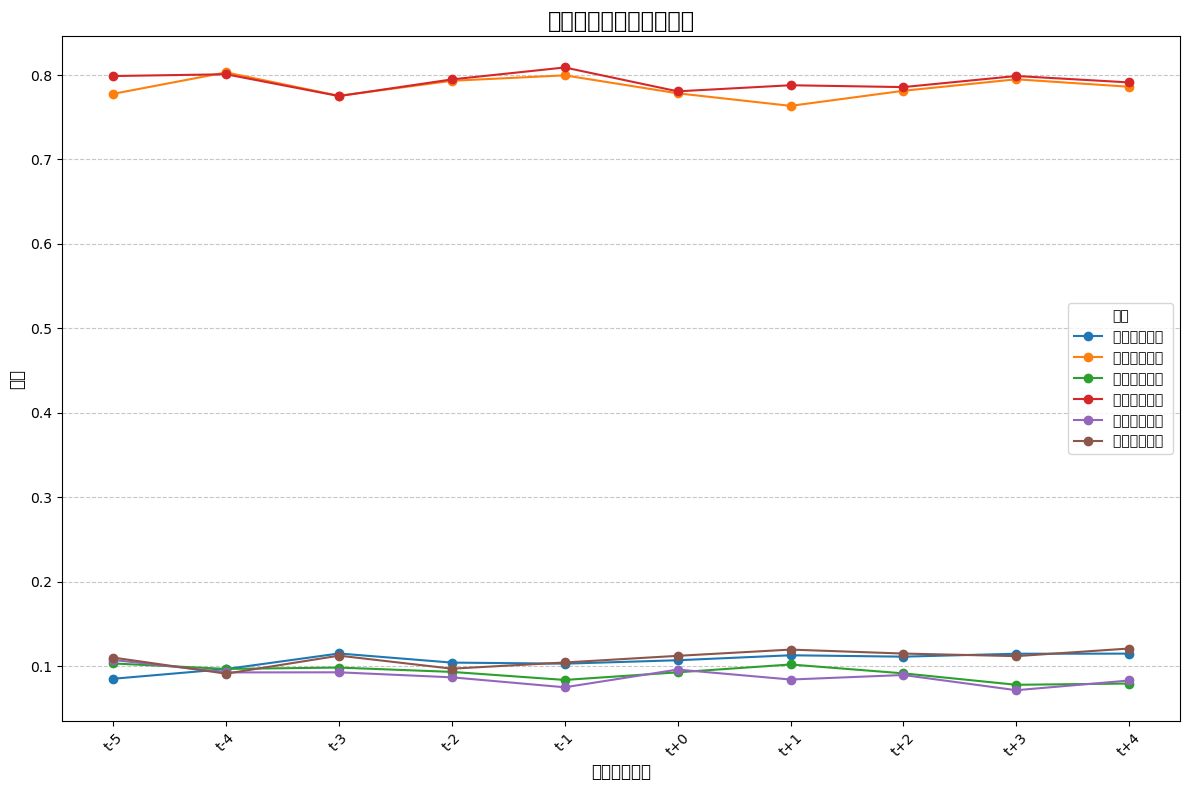

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
input_csv = "did_comments_test_group.csv"  # 替换为实际文件路径
df = pd.read_csv(input_csv)

# 提取以 "(t-" 或 "(t+" 开头的列，按类别分组
categories = set(col.split("(")[0] for col in df.columns if "(" in col)

# 绘制每一类列的折线图
plt.figure(figsize=(12, 8))

for category in categories:
    # 筛选属于该类别的列
    category_cols = [col for col in df.columns if col.startswith(category)]
    
    # 提取列并计算均值
    category_means = df[category_cols].mean(axis=0, skipna=True)
    
    # 获取时间相对位置作为横轴标签
    time_labels = [col.split("(")[-1].strip(")") for col in category_cols]
    
    # 绘制折线图
    plt.plot(time_labels, category_means, marker='o', linestyle='-', label=category)

# 图表美化
plt.title("情感分数均值随时间变化", fontsize=16)
plt.xlabel("时间相对位置", fontsize=12)
plt.ylabel("均值", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="类别", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 保存图表为文件或展示
plt.savefig("sentiment_means_over_time.png", dpi=300)
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体
rcParams['axes.unicode_minus'] = False  

# 读取 CSV 文件
input_csv = "merged_data.csv"  # 替换为实际文件路径
df = pd.read_csv(input_csv)

# 提取以 "(t-" 或 "(t+" 开头的列，按类别分组
categories = set(col.split("(")[0] for col in df.columns if "(" in col)

# 创建单独折线图
for category in categories:
    # 筛选属于该类别的列
    category_cols = [col for col in df.columns if col.startswith(category)]
    
    # 提取列并计算均值
    category_means = df[category_cols].mean(axis=0, skipna=True)
    
    # 获取时间相对位置作为横轴标签
    time_labels = [col.split("(")[-1].strip(")") for col in category_cols]
    
    # 动态调整 y 轴范围
    y_min = category_means.min() - abs(category_means.min() * 0.1)  # 最小值下调 10%
    y_max = category_means.max() + abs(category_means.max() * 0.1)  # 最大值上调 10%
    
    # 绘制折线图
    plt.figure(figsize=(8, 6))
    plt.plot(time_labels, category_means, marker='o', linestyle='-', label=category)
    
    # 图表美化
    plt.title(f"{category} 均值随时间变化", fontsize=16)
    plt.xlabel("时间相对位置", fontsize=12)
    plt.ylabel("均值", fontsize=12)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=45)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 保存或显示图表
    output_file = f"{category}_means_over_time.png"
    plt.savefig(output_file, dpi=300)
    plt.show()


EmptyDataError: No columns to parse from file

In [5]:
import os
import pandas as pd
from datetime import datetime

# 目标文件夹路径
folder_path = "D:\\mycodelife\\workshop\\fake_finance\\ready_crawler\\result"  # 替换为你的文件夹路径
output_csv = "did_comments_control_group.csv"

# 处理文件夹中所有文件
all_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# 初始化结果列表
result_list = []

# 日期格式转换工具
def parse_date(date_str):
    for fmt in ("%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return None  # 返回 None 表示格式不匹配

# 处理每个文件
file_with_problem = 0  # 记录问题文件数
for file in all_files:
    # 提取文件名中的股票代码和新闻发布时间
    stock_code, file_date_str = os.path.splitext(file)[0].split("_")
    file_date = parse_date(file_date_str)

    if file_date is None:
        print(f"文件名中的日期 {file_date_str} 格式无效，跳过文件：{file}")
        file_with_problem += 1
        continue

    # 将 base_date 统一转换为字符串格式 YYYY-MM-DD
    base_date = file_date.strftime("%Y-%m-%d")

    # 读取文件
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, dtype=str)

    # 确保日期列格式化为字符串 YYYY-MM-DD
    df["发布时间"] = pd.to_datetime(df["发布时间"], errors="coerce").dt.strftime("%Y-%m-%d")
    df = df.dropna(subset=["发布时间"])  # 丢弃无效的日期

    # 查找 t 的行
    if base_date not in df["发布时间"].values:
        print(base_date)
        print(df["发布时间"].values)
        print(file_path, "not in")
        file_with_problem += 1
        continue

    # 确定 t 的索引
    t_row = df[df["发布时间"] == base_date]
    t_index = t_row.index[0]

    # 提取 t-3 到 t+3 的行
    data_dict = {"股票代码": stock_code, "新闻发布时间": base_date}
    for offset in range(-4, 4):  # t-5 到 t+4
        col_suffix = f"(t{offset:+})"
        idx = t_index + offset
        if 0 <= idx < len(df):  # 确保索引合法
            row = df.iloc[idx]
            for col in df.columns:
                if col != "发布时间":  # 除发布时间外，其他列依次填入
                    data_dict[f"{col} {col_suffix}"] = row[col]
        else:
            # 填充 NA
            for col in df.columns:
                if col != "发布时间":
                    data_dict[f"{col} {col_suffix}"] = "NA"

    # 将结果添加到结果列表中
    result_list.append(data_dict)

# 汇总结果并导出 CSV
result_df = pd.DataFrame(result_list)
result_df.to_csv(output_csv, index=False, encoding="utf-8-sig")

print(f"处理完成，结果已保存为 {output_csv}")
print(f"共处理问题文件数：{file_with_problem}")


2016-11-25
['2016-07-03' '2016-07-05' '2016-11-21' '2016-11-29' '2016-12-08'
 '2016-12-16' '2016-12-19' '2016-12-20' '2016-12-21' '2016-12-22'
 '2016-12-23' '2016-12-24' '2016-12-25' '2016-12-26' '2016-12-27']
D:\mycodelife\workshop\fake_finance\ready_crawler\result\000038_2016-11-25.csv not in
2017-05-14
['2016-06-16' '2017-04-26' '2017-05-03' '2017-05-05' '2017-05-06'
 '2017-05-07' '2017-05-08' '2017-05-10' '2017-05-11' '2017-05-12'
 '2017-05-15' '2017-05-16' '2017-05-17' '2017-05-18' '2017-05-19'
 '2017-05-21' '2017-05-22' '2017-05-23' '2017-05-24' '2017-05-25'
 '2017-05-26' '2017-05-29' '2017-05-30' '2017-05-31' '2017-06-01'
 '2017-06-02' '2017-06-03' '2017-06-04' '2017-06-05' '2017-06-06'
 '2017-06-07' '2017-06-08' '2017-06-09' '2017-06-10' '2017-06-11'
 '2017-06-12']
D:\mycodelife\workshop\fake_finance\ready_crawler\result\000564_2017-05-14.csv not in
2022-04-22
['2021-11-02' '2021-11-30' '2022-01-08' '2022-01-16' '2022-01-17'
 '2022-02-09' '2022-02-16' '2022-02-21' '2022-03-15' 

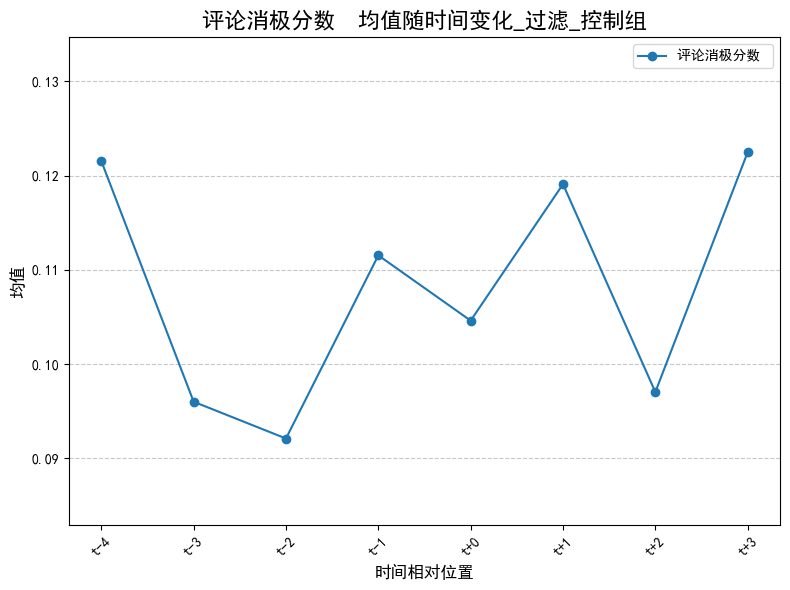

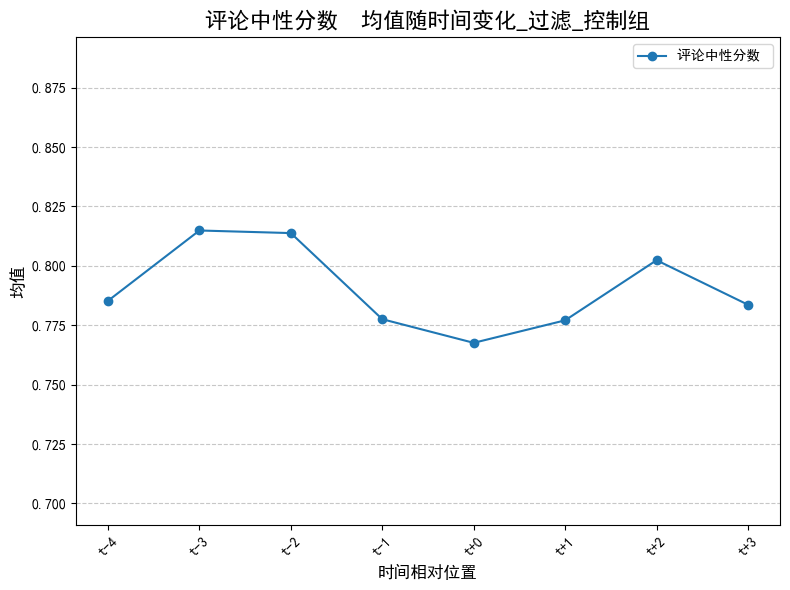

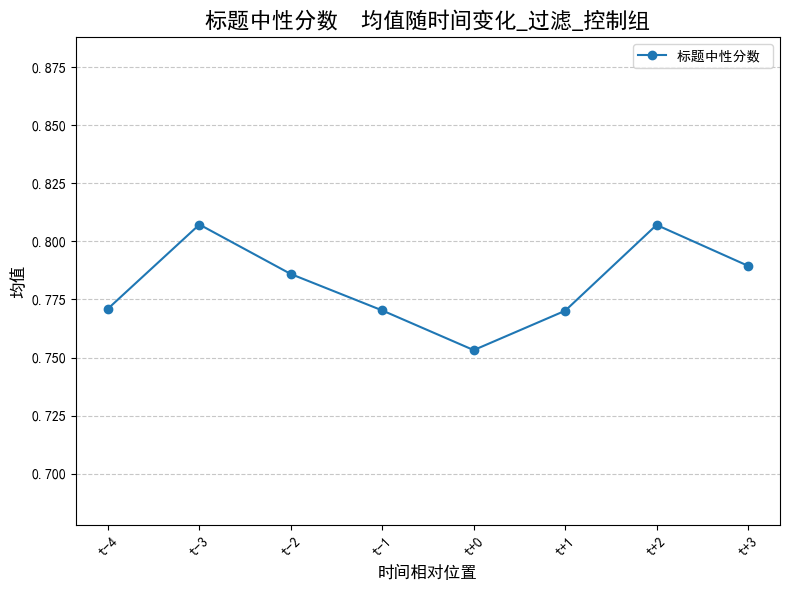

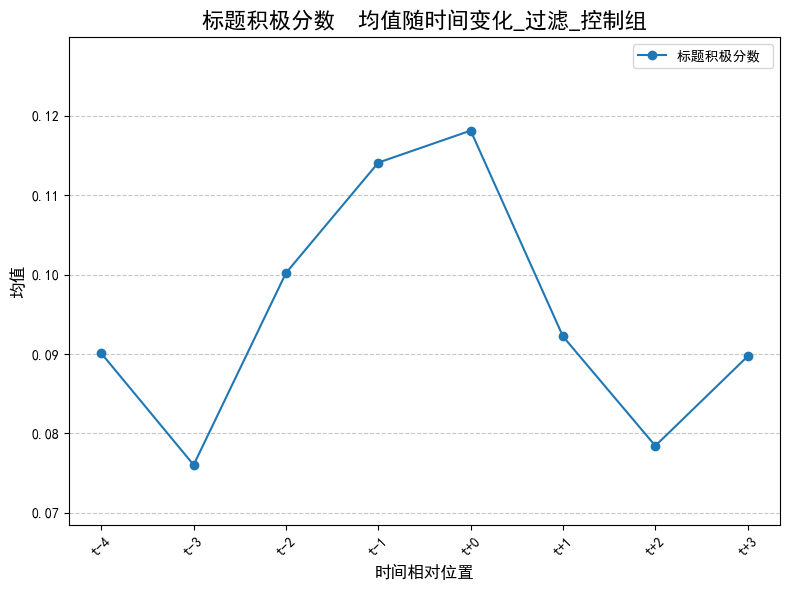

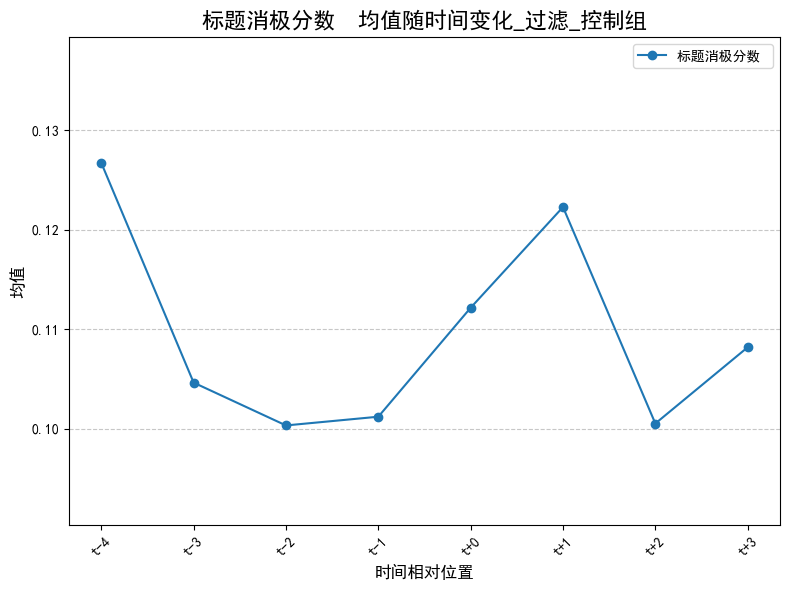

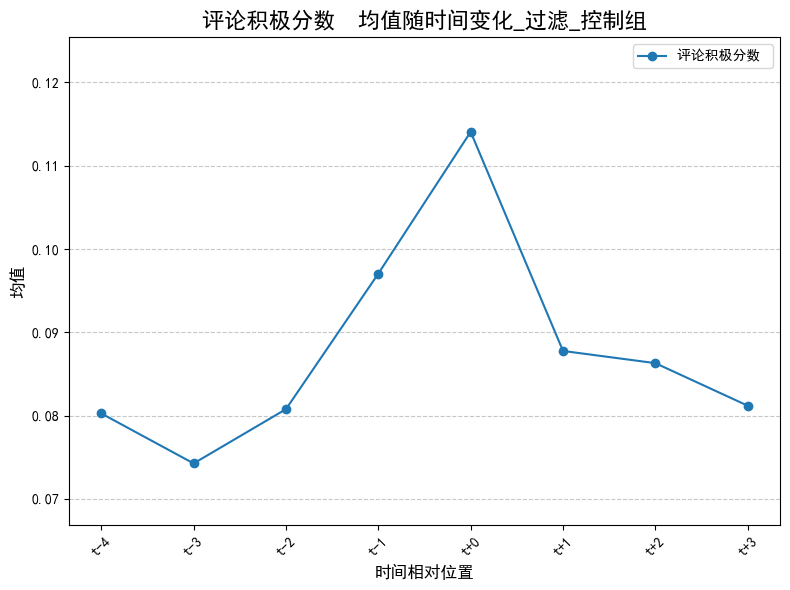

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体
rcParams['axes.unicode_minus'] = False  

# 读取 CSV 文件
input_csv = "did_comments_control_group.csv"  # 替换为实际文件路径
df = pd.read_csv(input_csv)

# 提取以 "(t-" 或 "(t+" 开头的列，按类别分组
categories = set(col.split("(")[0] for col in df.columns if "(" in col)

# 创建单独折线图
for category in categories:
    # 筛选属于该类别的列
    category_cols = [col for col in df.columns if col.startswith(category)]
    
    # 提取列并计算均值
    category_means = df[category_cols].mean(axis=0, skipna=True)
    
    # 获取时间相对位置作为横轴标签
    time_labels = [col.split("(")[-1].strip(")") for col in category_cols]
    
    # 动态调整 y 轴范围
    y_min = category_means.min() - abs(category_means.min() * 0.1)  # 最小值下调 10%
    y_max = category_means.max() + abs(category_means.max() * 0.1)  # 最大值上调 10%
    
    # 绘制折线图
    plt.figure(figsize=(8, 6))
    plt.plot(time_labels, category_means, marker='o', linestyle='-', label=category)
    
    # 图表美化
    plt.title(f"{category} 均值随时间变化_过滤_控制组", fontsize=16)
    plt.xlabel("时间相对位置", fontsize=12)
    plt.ylabel("均值", fontsize=12)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=45)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 保存或显示图表
    output_file = f"{category}_means_over_time_control_group.png"
    plt.savefig(output_file, dpi=300)
    plt.show()


# 正式开始DID

先合并数据

In [16]:
import pandas as pd
from charset_normalizer import detect
# 文件路径
file_a_path = "data_china.xlsx"  # 主文件 A 的路径
file_b_path = "did_comments_test_group.csv"  # 文件 B 的路径
file_c_path = "badrdsai_result_title_test.xlsx"  # 文件 C 的路径
file_d_path = "badrdsai_analysis_content_test.xlsx"  # 文件D的路径
output_path = "test_group_all_data.xlsx" # 文件输出
'''
with open(file_c_path, 'rb') as f:
    raw_data = f.read()
    result = detect(raw_data)
    print(result)

# 使用检测到的编码读取文件
encoding = result['encoding']
df_c = pd.read_csv(file_c_path, encoding=encoding)

with open(file_d_path, 'rb') as f:
    raw_data = f.read()
    result = detect(raw_data)
    print(result)

# 使用检测到的编码读取文件
encoding = result['encoding']
df_c = pd.read_csv(file_d_path, encoding=encoding)
# 读取文件
df_a = pd.read_excel(file_a_path, dtype=str)  # 主文件 A
df_b = pd.read_csv(file_b_path, dtype=str)  # 文件 B
'''

# 读取文件
df_a = pd.read_excel(file_a_path, sheet_name= 1,dtype=str)  # 主文件 A
df_b = pd.read_csv(file_b_path, dtype=str)  # 文件 B
df_c = pd.read_excel(file_c_path, dtype=str) 
df_d = pd.read_excel(file_d_path, dtype=str) 
# 确保主码的列名和格式一致
key_columns = ["股票代码", "新闻发布时间"]  # 定义主码列
df_a[key_columns[1]] = pd.to_datetime(df_a[key_columns[1]], errors="coerce").dt.strftime("%Y-%m-%d")
df_b[key_columns[1]] = pd.to_datetime(df_b[key_columns[1]], errors="coerce").dt.strftime("%Y-%m-%d")
df_c[key_columns[1]] = pd.to_datetime(df_c[key_columns[1]], errors="coerce").dt.strftime("%Y-%m-%d")
df_d[key_columns[1]] = pd.to_datetime(df_c[key_columns[1]], errors="coerce").dt.strftime("%Y-%m-%d")

# 按照主码进行合并
merged_df = df_a.merge(df_b, on=key_columns, how="left")  # 左连接 A 和 B
merged_df = merged_df.merge(df_c, on=key_columns, how="left")  # 左连接结果和 C
merged_df = merged_df.merge(df_d, on=key_columns, how="left") # 左连接结果和 D

# 导出结果
merged_df.to_excel(output_path, index=False)
print(f"文件合并完成，结果保存为 {output_path}")


文件合并完成，结果保存为 test_group_all_data.xlsx


试一试断点回归

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 假设df_cleaned是已经清理过的数据，包含我们需要的列
# 请根据数据集列名调整控制变量选择
# 因变量
Y_vars = ['新闻标题情绪分数', '评论中性分数']  # 你可以根据需求选择不同的因变量

# 自变量
X_var = '新闻内容中性分数'

# 控制变量，从L到U范围的情绪分数
control_vars = ['新闻内容积极分数', '新闻内容消极分数']  # 控制变量的选择

# 进行断点回归
def run_did_regression(df, Y_var, X_var, control_vars):
    # 断点：以发布时间中位数为断点
    breakpoint_date = df['新闻发布时间'].median()
    df['断点'] = (df['新闻发布时间'] >= breakpoint_date).astype(int)
    
    # 构建回归公式：因变量 ~ 自变量 + 断点 + 自变量与断点交互项 + 控制变量
    formula = f"{Y_var} ~ {X_var} + 断点 + {X_var}:断点 + " + " + ".join(control_vars)
    
    # 使用OLS进行回归分析
    model = smf.ols(formula, data=df).fit()
    return model

# 绘制回归结果图
def plot_regression_results(df, Y_var, X_var, model, breakpoint_date):
    # 绘制自变量X与因变量Y的关系，分开干预前后（断点前后）
    plt.figure(figsize=(10, 6))
    
    # 断点前的数据点
    before_break = df[df['新闻发布时间'] < breakpoint_date]
    plt.scatter(before_break[X_var], before_break[Y_var], label="干预前", color='blue', alpha=0.6)
    
    # 断点后的数据点
    after_break = df[df['新闻发布时间'] >= breakpoint_date]
    plt.scatter(after_break[X_var], after_break[Y_var], label="干预后", color='red', alpha=0.6)
    
    # 绘制回归线
    X_vals = np.linspace(df[X_var].min(), df[X_var].max(), 100)
    y_vals = model.predict(pd.DataFrame({X_var: X_vals, '断点': [0]*100, X_var+':断点': [0]*100}))
    plt.plot(X_vals, y_vals, label="干预前预测", color='blue', linestyle='--')
    
    y_vals_after = model.predict(pd.DataFrame({X_var: X_vals, '断点': [1]*100, X_var+':断点': [1]*100}))
    plt.plot(X_vals, y_vals_after, label="干预后预测", color='red', linestyle='--')

    # 图标设置
    plt.xlabel(X_var)
    plt.ylabel(Y_var)
    plt.title(f"断点回归分析: {Y_var} ~ {X_var}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 对每个因变量进行回归分析和绘图
for Y_var in Y_vars:
    print(f"Running regression for {Y_var}...")
    model = run_did_regression(df_cleaned, Y_var, X_var, control_vars)
    print(model.summary())
    plot_regression_results(df_cleaned, Y_var, X_var, model, breakpoint_date)
